In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [2]:
PATH = 'data/New_DB.xlsx'
df = pd.read_excel(PATH)

columns =['slope', 'PP', 'valor_humedad_suelo1']
X = df.loc[:,columns]
train_size = 0.80
df_general = X * 1
n_df_general = X * 0.8
df_general['output'] = 1
n_df_general['output'] = 0

df_output = pd.concat([df_general, n_df_general])

X_slope_PP = df_output.drop('valor_humedad_suelo1', axis=1)
X_slope_PP_vhs1 = df_output

X_slope_PP = X_slope_PP.dropna()
X_slope_PP_vhs1 = X_slope_PP_vhs1.dropna()
X_slope_PP = X_slope_PP.reset_index(drop=True)
X_slope_PP_vhs1 = X_slope_PP_vhs1.reset_index(drop=True)

y_slope_PP = X_slope_PP.output
X_slope_PP = X_slope_PP.drop(labels='output', axis=1)

y_slope_PP_vhs1 = X_slope_PP_vhs1.output
X_slope_PP_vhs1 = X_slope_PP_vhs1.drop(labels='output', axis=1)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pytensor
import pytensor.tensor as pt

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=train_size, stratify=y_slope_PP_vhs1, random_state=42)
sc = StandardScaler()
floatX = pytensor.config.floatX
#X_slope_PP_vhs1 = X_slope_PP_vhs1.astype(floatX)
#y_slope_PP_vhs1 = y_slope_PP_vhs1.astype(floatX)
X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=train_size, stratify=y_slope_PP_vhs1,random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

random_seed = 12
rng = np.random.default_rng(random_seed)

In [4]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train, mutable=True, dims=("obs_id", "train_cols"))
        ann_output = pm.Data("ann_output", y_train, mutable=True, dims="obs_id")

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=y_train.shape[0],  # IMPORTANT for minibatches
            dims="obs_id",
        )
    return neural_network


neural_network_ = construct_nn(X_train, y_train)

In [5]:
def bayesian_regression_tree(input, output):
    coords = {
        'train_cols': np.arange(X_train.shape[1]),
        #'obs_id': np.arange(X_train.shape[0])
    }
    with pm.Model(coords=coords) as model:
        input = pm.Data('input', X_train, mutable=True, dims=('obs_id','train_cols'))
        observed = pm.Data('observed', y_train, mutable=True, dims='dims_id')
        intercept = pm.Normal('intercept', mu = 0, sigma = 5) #5
        beta = pm.Normal('beta',mu=0, sigma=5)
        beta2 = pm.Normal('beta2', mu=0, sigma=5)
        beta3 = pm.Normal('beta3', mu = 0, sigma=5)
        alpha = pm.Normal('alpha', mu = 0, sigma=0.1)
        alpha2 = pm.Normal('alpha2', mu = 0, sigma = 0.1) #0.1
        alpha3 = pm.Normal('alpha3', mu = 0, sigma=1)
        alpha4 = pm.Normal('alpha4', mu = 0, sigma = 0.1) #0.1
        alpha5 = pm.Normal('alpha5', mu = 0 , sigma = 1) #1
        alpha6 = pm.Normal('alpha6', mu = 0 , sigma = 1) #1
        p = pm.Deterministic(
            'p', 
            pm.math.invlogit(
                intercept + input[:,0]*beta + input[:,1]*beta2 + input[:,2]*beta3 + 
                (input[:,1]**2)*alpha**2 + (input[:,2]**2)*alpha2**2 + (input[:,0]**2)*alpha3**2 + 
                (input[:,1]**3)*alpha4**3 + (input[:,2]**3)*alpha5**3 + (input[:,0]**3)*alpha6**3))
        final = pm.Bernoulli('out',p , observed = observed, dims='obs_id')
        
    return model

bayesian_regression_tree_ = bayesian_regression_tree(X_train, y_train)

In [6]:
def modelo_formula_cov(input, output):
    coords = {
        'train_cols': np.arange(X_train.shape[1]),
        #'obs_id': np.arange(X_train.shape[0])
    }
    with pm.Model(coords=coords) as model:
        input = pm.Data('input', X_train, mutable=True, )#dims=('obs_id','train_cols'))
        observed = pm.Data('observed', y_train, mutable=True, )#dims='dims_id')
        intercept = pm.Normal('intercept', mu=0,sigma=5)
    
        beta_1 = pm.Normal('beta_1',mu=0, sigma=5)
        beta_2 = pm.Normal('beta_2', mu=0, sigma=5)
        beta_3 = pm.Normal('beta_3', mu = 0, sigma=5)
        p = pm.Deterministic(
            'p', 
            pm.math.invlogit(
                intercept + input[:,0]*beta_1 + input[:,1]*beta_2 + input[:,2]*beta_3
            ))
            
        out = pm.Bernoulli('out', p, observed = observed,)# dims='obs_id')
    return model

modelo_formula_cov_ = modelo_formula_cov(X_train, y_train)

In [7]:
def train_nn_model(model):
    with model:
        approx = pm.fit(n=20_000)
    trace = approx.sample(draws=5000)
    with model:
        pm.set_data(new_data={"ann_input": X_test})
        ppc = pm.sample_posterior_predictive(trace)
        trace.extend(ppc)

    pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
    print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")
    return pred.values, trace

In [8]:
def train_model(model):
    with model:
        start = pm.find_MAP()
        #hessian_inv = np.linalg.inv(pm.find_hessian(start, model=bayesian_regression_tree))
        approx = pm.fit(n=10_000, start=start)
        step = pm.Metropolis()
        trace = approx.sample(draws=5000,)#step = step, start = start)# nuts_sampler_kwargs={'hess_inv': hessian_inv})

    with model:
        pm.set_data(new_data={"input": X_test})
        ppc = pm.sample_posterior_predictive(trace, var_names=['p'], return_inferencedata=True, predictions=True, extend_inferencedata=True)
        trace.extend(ppc)
    #pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
    #print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")
    pred = ppc.predictions['p'].mean(('chain', 'draw')) > 0.5
    print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")
    return pred.values, trace 
    

In [16]:
import pickle
def save_model(model, name_model, name_trace):
    with model:
        start = pm.find_MAP()
        #hessian_inv = np.linalg.inv(pm.find_hessian(start, model=bayesian_regression_tree))
        approx = pm.fit(n=10_000, start=start)
        step = pm.Metropolis()
        trace = approx.sample(draws=5000,)#step = step, start = start)# nuts_sampler_kwargs={'hess_inv': hessian_inv})

    """with open(f'{name_model}.pkl', 'wb') as f:
        pickle.dump(model, f)"""

    with open(f'{name_trace}.pkl', 'wb') as f:
        pickle.dump(trace, f)
        
def save_model_nn(model, name_model, name_trace):
    with model:
        approx = pm.fit(n=20_000)
    trace = approx.sample(draws=5000)

    """with open(f'{name_model}.pkl', 'wb') as f:
        pickle.dump(model, f)"""
    with open(f'{name_trace}.pkl', 'wb') as f:
        pickle.dump(trace, f)

In [17]:
"""y_score_nn, trace_nn = train_nn_model(neural_network_)
y_score_bayesian, trace_bayesian = train_model(bayesian_regression_tree_)
y_score_cov, trace_cov = train_model(modelo_formula_cov_)"""

'y_score_nn, trace_nn = train_nn_model(neural_network_)\ny_score_bayesian, trace_bayesian = train_model(bayesian_regression_tree_)\ny_score_cov, trace_cov = train_model(modelo_formula_cov_)'

In [18]:
save_model(bayesian_regression_tree_, 'bayesian_regression_tree', 'trace_bayesian')
save_model(modelo_formula_cov_, 'modelo_formula_cov', 'trace_cov')
save_model_nn(neural_network_, 'neural_network', 'trace_nn')

Finished [100%]: Average Loss = 167.49


Finished [100%]: Average Loss = 151.32


Finished [100%]: Average Loss = 191.19


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


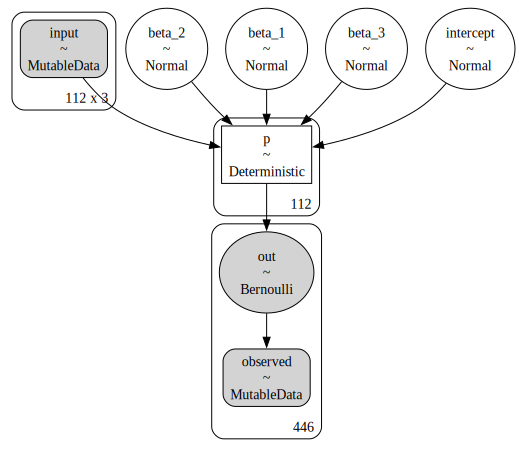

In [ ]:
pm.model_to_graphviz(modelo_formula_cov)

In [ ]:
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve, classification_report, ConfusionMatrixDisplay) 
from sklearn.metrics import recall_score, precision_score, classification_report

In [ ]:
y_score = pred

NameError: name 'pred' is not defined

In [ ]:
def curvas_metricas(y_test, y_score):
    pred_scores = dict(y_true=y_test, y_score=y_score)
    cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
    roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))
    precision, recall, ts = precision_recall_curve(y_true=y_test, probas_pred=y_score)
    pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})
    f1 = pd.Series({t: f1_score(y_true=y_test, y_pred=y_score>t) for t in ts})
    best_threshold = f1.idxmax()
    fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

    ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, s=50, legend=False, ax=axes[0])
    axes[0].plot('False Positive Rate', 'True Positive Rate', data=roc, lw=1, color='k')
    axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
    axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.3, color='red')
    axes[0].set_title('Receiver Operating Characteristic')


    sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
    axes[1].set_ylim(0,1)
    axes[1].set_title('Precision-Recall Curve')


    f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
    axes[2].set_xlabel('Threshold')
    axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
    #axes[2].text(text=f'Max F1 @ {best_threshold:.2f}', x=.60, y=.95, s=5)
    fig.suptitle(f'roc_auc_score = {round(roc_auc_score(**pred_scores),2)}', fontsize=24)
    fig.tight_layout()
    plt.subplots_adjust(top=.8)
    plt.show();



In [ ]:
def metricas_cm(y_test, y_score):
    recall = recall_score(y_test, y_score)
    precision = precision_score(y_test,y_score)
    print(f'RECALL:{recall: .3f}\nPRECISION:{precision: .3f}')
    confusion_matrix_ = confusion_matrix(y_test, y_score)
    disp = ConfusionMatrixDisplay(confusion_matrix_)
    disp.plot()
    plt.show()


RECALL: 0.946
PRECISION: 0.883


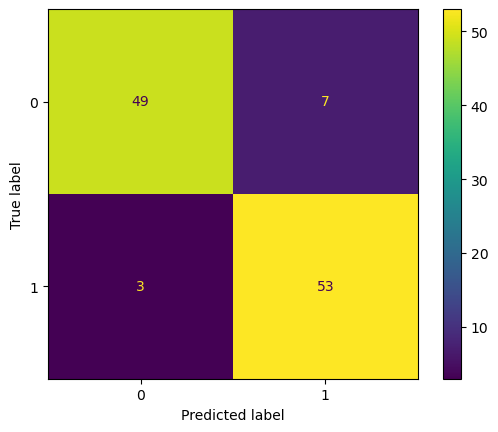

In [ ]:
"""
TN FP
FN TP
"""
metricas_cm(y_test, y_score)

In [ ]:
"""
proyecto-remociones-en-masa/
│
├── data/
│   ├── raw/
│   │   ├── datos_crudos.csv
│   ├── processed/
│       ├── datos_preprocesados.csv
│
├── modelos/
│   ├── entrenamiento/
│       ├── train_model.ipynb
│   ├── inferencia/
│       ├── inferencia_modelo.ipynb
│
├── otro/
│   ├── utilidades.py
│   ├── exploracion_datos.ipynb
│
├── requirements.txt
├── README.md
├── LICENSE
"""

'\nproyecto-remociones-en-masa/\n│\n├── data/\n│   ├── raw/\n│   │   ├── datos_crudos.csv\n│   ├── processed/\n│       ├── datos_preprocesados.csv\n│\n├── modelos/\n│   ├── entrenamiento/\n│       ├── train_model.ipynb\n│   ├── inferencia/\n│       ├── inferencia_modelo.ipynb\n│\n├── otro/\n│   ├── utilidades.py\n│   ├── exploracion_datos.ipynb\n│\n├── requirements.txt\n├── README.md\n├── LICENSE\n'